In [1]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from IPython import display
display.set_matplotlib_formats("svg")

C:\Users\Admin\AppData\Local\Temp\ipykernel_10220\906459842.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [2]:
data = pd.read_csv("mnist_train_small.csv", header=None)

# extract labels (number ID's) and remove from data
labels = data.values[:, 0]  # Convert DataFrame to NumPy before slicing
data = data.values[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data/np.max(data)

In [3]:
# Step 1: convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# Step 2: use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size = .1)

# Step 3: convert into Pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Step 4: translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [4]:
# creating a class for the model
def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(784, 64)

            # hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # output layer
            self.output = nn.Linear(32, 10)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr = .01) # Adam performs way too good for this model therefore we used SGD

    return net, lossfun, optimizer

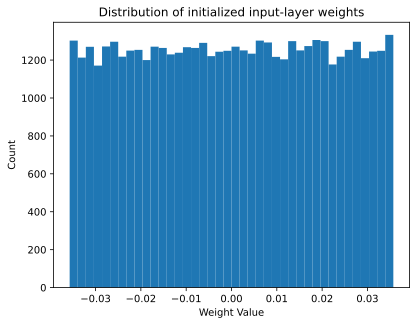

In [8]:
# test the model with one batch
net = createTheMNISTNet()[0]

# summary of the entire model
# print("Summary of model:")
# print(net)
# print(" ")

# explore one of the layers
# print("Summary of input layer:")
# print(vars(net.input))
# print(" ")

# check out the matrix of weights
# print("Input layer weights:")
# print(net.input.weight.shape)
# print(net.input.weight)
# print(" ")

# finally extract the weights and make a histogram
w = net.input.weight.detach().flatten()
plt.hist(w, 40)
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.title("Distribution of initialized input-layer weights")
plt.show()

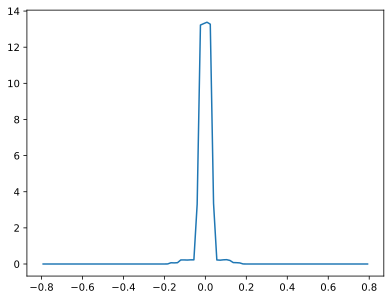

In [11]:
import numpy as np
import torch

def weightHistogram(net):
    # Initialize weight vector
    W = np.array([])

    # Concatenate all weights across layers
    for param in net.parameters():
        W = np.concatenate((W, param.detach().flatten().numpy()))

    # Compute histogram (range is hard-coded)
    histy, histx = np.histogram(W, bins=np.linspace(-0.8, 0.8, 101), density=True) 
    histx = (histx[1:] + histx[:-1]) / 2  # Convert bin edges to bin centers

    return histx, histy

# Example usage
import matplotlib.pyplot as plt

histx, histy = weightHistogram(net)
plt.plot(histx, histy)
plt.show()

In [14]:
 # train the model

def trainTheModel():

    # training parameter
    numepochs = 100
    
    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)

    # initilize losses and accuracies
    histx = np.zeros((numepochs, 100))
    histy = np.zeros((numepochs, 100))
    
    # train the model
    for epochi in range(numepochs):

        # get the weights distribution at the start of this epoch
        histx, histy[epochi, :] = weightHistogram(net)
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad():
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net, histx, histy

In [15]:
trainAcc, testAcc, losses, net, histx, histy = trainTheModel()

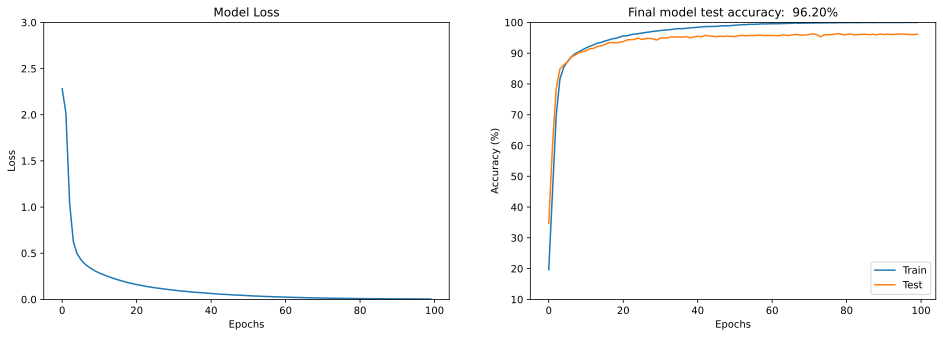

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].plot(losses)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_ylim([0, 3])
ax[0].set_title("Model Loss")

ax[1].plot(trainAcc, label = "Train")
ax[1].plot(testAcc, label = "Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_ylim([10, 100])
ax[1].set_title(f"Final model test accuracy: {testAcc[-1]: .2f}%")
ax[1].legend()

plt.show()

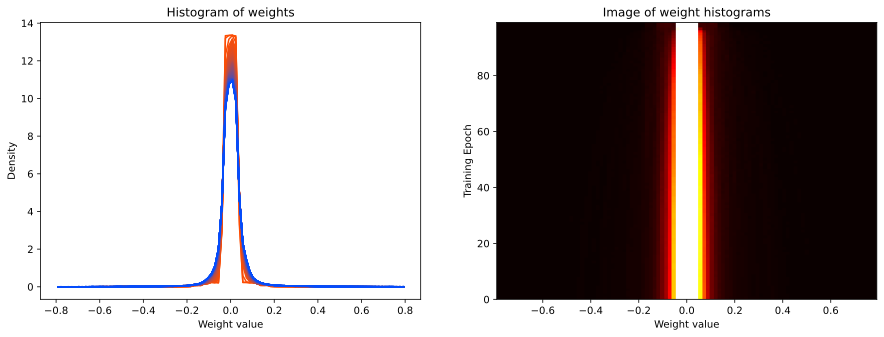

In [18]:
# show the histogram of the weights

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(histy.shape[0]):
    ax[0].plot(histx, histy[i, :], color = [1 - i/100, .3, i/100])

ax[0].set_title("Histogram of weights")
ax[0].set_xlabel("Weight value")
ax[0].set_ylabel("Density")

ax[1].imshow(histy, vmin = 0, vmax = 3, extent = [histx[0], histx[-1], 0, 99], aspect = "auto", origin = "upper", cmap = "hot")
ax[1].set_xlabel("Weight value")
ax[1].set_ylabel("Training Epoch")
ax[1].set_title("Image of weight histograms")

plt.show()